In [15]:
from google.colab import drive
drive.mount('/content/gdrive')
!cd /content/gdrive/MyDrive/ComputerVision/ImageCaption/

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [16]:
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
import string
import os
import re
from PIL import Image
import glob
import pickle
from pickle import load
from time import time
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Embedding, Dense, Flatten, Reshape, concatenate, Dropout
from tensorflow.keras.optimizers import Adam
from keras.layers.merge import add
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras import Input, layers
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [17]:
# load descriptions
def load_doc(filename):
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

filename = "/content/gdrive/MyDrive/ComputerVision/ImageCaption/Furniture-Dataset/Label-Furniture-Descriptions/Furniture-All-Descriptions.txt"
# load descriptions
doc = load_doc(filename)

In [18]:
def load_descriptions(doc):
    mapping = dict()
    for line in doc.split('\n'):
        tokens = line.split("\t")
        if len(line) < 2:
            continue
        image_id, image_desc = tokens[0], tokens[1:]
        image_id = image_id.split('.')[0]
        image_desc = ' '.join(image_desc)
        if image_id not in mapping:
            mapping[image_id] = list()
        mapping[image_id].append(" : " + image_desc)
    return mapping

descriptions = load_descriptions(doc)
print("Total Loaded :  " , len(descriptions))

Total Loaded :   55


In [19]:
def clean_descriptions(descriptions):
    table = str.maketrans('', '', string.punctuation)
    for key, desc_list in descriptions.items():
        for i in range(len(desc_list)):
            desc = desc_list[i]
            tokens = desc.split()
            # prepare regex for char filtering
            re_punc = re.compile('[%s]' % re.escape(string.punctuation))
            # remove punctuation from each word
            tokens = [re_punc.sub('', w) for w in tokens]
            # remove remaining tokens that are not alphabetic
            tokens = [word for word in tokens if word.isalpha()]
            tokens = [word.lower() for word in tokens]
            tokens = [word for word in tokens if len(word) > 1]
            desc_list[i] = ' '.join(tokens)

            
clean_descriptions(descriptions)

In [20]:
def to_vocabulary(descriptions):
    all_desc = set()
    for key in descriptions.keys():
        [all_desc.update(d.split()) for d in descriptions[key]]
    return all_desc

vocabulary = to_vocabulary(descriptions)
print('Original Vocabulary Size: {}'.format(len(vocabulary)))

Original Vocabulary Size: 80


In [21]:
def save_descriptions(descriptions, filename):
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + ' : ' + desc)
    data = '\n'.join(lines)
    file = open(filename, 'w')
    file.write(data)
    file.close()

save_descriptions(descriptions, '/content/gdrive/MyDrive/ComputerVision/ImageCaption/Furniture-Dataset/text_features/descriptions.txt')

In [22]:
# code to split all images into train and test, with image identifier files

# DO NOT UNCOMMENT




# all_images = [item+"._image_0.jpg" for item in descriptions.keys()]
# furniture_train_images, furniture_test_images = train_test_split(all_images, train_size = 0.9,  random_state= 412, shuffle=True)

# textfile = open("/content/gdrive/MyDrive/ComputerVision/ImageCaption/Furniture-Dataset/Label-Furniture-Descriptions/Furniture_train_images.txt", "w")
# for element in furniture_train_images:
#     textfile.write(element + "\n")
# textfile.close()
# textfile = open("/content/gdrive/MyDrive/ComputerVision/ImageCaption/Furniture-Dataset/Label-Furniture-Descriptions/Furniture_test_images.txt", "w")
# for element in furniture_test_images:
#     textfile.write(element + "\n")
# textfile.close()

In [23]:
#load a pre-defined list of photo identifiers
def load_set(descriptions):
    doc = load_doc(filename)
    dataset = list()
    for line in doc.split('\n'):
        if len(line) < 1:
            continue
        identifier = line.split('.')[0]
        dataset.append(identifier)
    return set(dataset)

# load training dataset 
filename = '/content/gdrive/MyDrive/ComputerVision/ImageCaption/Furniture-Dataset/Label-Furniture-Descriptions/Furniture_train_images.txt'
train = load_set(filename)
print('Total Training Dataset: {}'.format(len(train)))

Total Training Dataset: 49


In [28]:
# Below path contains all the images
images = '/content/gdrive/MyDrive/ComputerVision/ImageCaption/Furniture-Dataset/images_for_clip_do_not_modify/'
# Create a list of all image names in the directory
img = glob.glob(images + '*.jpg')

In [29]:
len(img)

55

In [30]:
train_images_file = '/content/gdrive/MyDrive/ComputerVision/ImageCaption/Furniture-Dataset/Label-Furniture-Descriptions/Furniture_train_images.txt'
train_images = set(open(train_images_file, 'r').read().strip().split('\n'))

train_img = []

for i in img: 
    if i[len(images):] in train_images:
        train_img.append(i) 

In [31]:
len(train_img)

49

In [32]:
# train_img[0]

In [33]:
# Create a list of all the testing images with their full path names
test_images_file = '/content/gdrive/MyDrive/ComputerVision/ImageCaption/Furniture-Dataset/Label-Furniture-Descriptions/Furniture_test_images.txt'
test_images = set(open(test_images_file, 'r').read().strip().split('\n'))

test_img = []

for i in img: 
    if i[len(images):] in test_images:
        test_img.append(i) 

In [34]:
# load clean descriptions into memory
def load_clean_descriptions(filename, dataset):
    doc = load_doc(filename)
    descriptions = dict()
    for line in doc.split('\n'):
        tokens = line.split(" : ")
        image_id, image_desc = tokens[0], tokens[1:]
        if image_id in dataset:
            if image_id not in descriptions:
                descriptions[image_id] = list()
            desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
            descriptions[image_id].append(desc)
    return descriptions

descriptions = '/content/gdrive/MyDrive/ComputerVision/ImageCaption/Furniture-Dataset/text_features/descriptions.txt'
train_descriptions = load_clean_descriptions( descriptions, train)
del train_descriptions['Abstract Design XXL Bean Bag Cover in Multicolour by Style HomeZ']
print('Descriptions: Train : {}'.format(len(train_descriptions)))

Descriptions: Train : 48


In [35]:
#preprocessing the images
def preprocess(image_path):
    img = image.load_img(image_path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

In [36]:
# Load the inception v3 model
model = InceptionV3(weights='imagenet')
# Create a new model, by removing the last layer (output layer) from the inception v3
model_new = Model(model.input, model.layers[-2].output)

96124928/96112376 [==============================] - 1s 0us/step


In [37]:
# Encoding a given image into a vector of size (2048, )
def encode(image):
    image = preprocess(image) 
    fea_vec = model_new.predict(image) 
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1])
    return fea_vec

In [38]:
# Encoding all the train images 
start = time()
encoding_train = {}
for img in train_img:
    encoding_train[img[len(images):]] = encode(img)
print("Time taken in seconds =", time()-start)

Time taken in seconds = 50.432573318481445


In [39]:
# Save the bottleneck train features to disk
with open("/content/gdrive/MyDrive/ComputerVision/ImageCaption/Furniture-Dataset/image_features/encoded_train_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_train, encoded_pickle)

In [40]:
len(encoding_train)

49

In [41]:
# Call the funtion to encode all the test images - Execute this only once
start = time()
encoding_test = {}
for img in test_img:
    encoding_test[img[len(images):]] = encode(img)
print("Time taken in seconds =", time()-start)

Time taken in seconds = 6.204927444458008


In [42]:
# Save the bottleneck train features to disk
with open("/content/gdrive/MyDrive/ComputerVision/ImageCaption/Furniture-Dataset/image_features/encoded_test_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_test, encoded_pickle)

In [43]:
train_features = load(open("/content/gdrive/MyDrive/ComputerVision/ImageCaption/Furniture-Dataset/image_features/encoded_train_images.pkl", "rb"))
print('Photos: Training: {}'.format(len(train_features)))

Photos: Training: 49


In [44]:
# Create a list of all the training captions
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)
len(all_train_captions)

144

In [45]:
type(all_train_captions)

list

In [46]:
# Consider only words which occur at least 10 times in the corpus
#word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts.keys() ]
print('Preprocessed words {} -> {}'.format(len(word_counts), len(vocab)))

Preprocessed words 74 -> 74


In [47]:
ixtoword = {}
wordtoix = {}

ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

In [48]:
vocab_size = len(ixtoword) + 1 # one for appended 0's
vocab_size

75

In [49]:
# convert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
    all_desc = list()
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

# calculate the length of the description with the most words
def max_length(descriptions):
    lines = to_lines(descriptions)
    return max(len(d.split()) for d in lines)

# determine the maximum sequence length
max_length1 = max_length(train_descriptions)
print('Maximum Description Length: {}'.format(max_length1))

Maximum Description Length: 15


In [50]:
# data generator, intended to be used in a call to model.fit_generator()
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key+'._image_0.jpg']
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            # yield the batch data
            if n==num_photos_per_batch:
                yield [[array(X1), array(X2)], array(y)]
                X1, X2, y = list(), list(), list()
                n=0

In [51]:
# Load Glove vectors
glove_dir = '/content/gdrive/MyDrive/ComputerVision/ImageCaption/Dataset/glove.6B.200d'
embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.200d.txt'), encoding="utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found {} word vectors.'.format(len(embeddings_index)))

Found 400000 word vectors.


In [52]:
embedding_dim = 200

# Get 200-dim dense vector for each of the words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoix.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [53]:
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(max_length1,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [54]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 15)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 15, 200)      15000       ['input_3[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 2048)         0           ['input_2[0][0]']                
                                                                                            

In [55]:
model.compile(loss='categorical_crossentropy', optimizer='adam')
epochs = 20
number_pics_per_batch = 3
steps = len(train_descriptions)//number_pics_per_batch
generator = data_generator(train_descriptions, train_features, wordtoix, max_length1, number_pics_per_batch)
history = model.fit_generator(generator, epochs=20,  steps_per_epoch=steps, verbose=1)
model.save('saved_model/model_' + str(20) + '.h5')

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


16/16 [==============================] - 6s 110ms/step - loss: 3.9142
Epoch 2/20
16/16 [==============================] - 2s 108ms/step - loss: 3.2209
Epoch 3/20
16/16 [==============================] - 2s 110ms/step - loss: 2.6304
Epoch 4/20
16/16 [==============================] - 2s 109ms/step - loss: 2.1073
Epoch 5/20
16/16 [==============================] - 2s 107ms/step - loss: 1.7602
Epoch 6/20
16/16 [==============================] - 2s 109ms/step - loss: 1.6523
Epoch 7/20
16/16 [==============================] - 2s 108ms/step - loss: 1.5629
Epoch 8/20
16/16 [==============================] - 2s 110ms/step - loss: 1.3473
Epoch 9/20
16/16 [==============================] - 2s 110ms/step - loss: 1.2002
Epoch 10/20
16/16 [==============================] - 2s 109ms/step - loss: 1.0867
Epoch 11/20
16/16 [==============================] - 2s 109ms/step - loss: 0.9380
Epoch 12/20
16/16 [==============================] - 2s 110ms/step - loss: 0.8379
Epoch 13/20
16/16 [=================

Text(0.5, 1.0, 'First 20 Epochs')

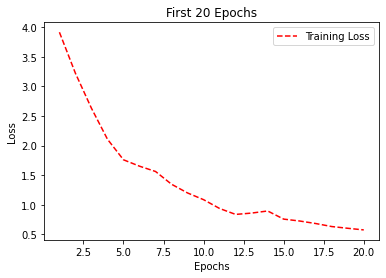

In [56]:
training_loss = history.history['loss']
epoch_count = range(1, len(training_loss) + 1)
plt.figure()  
    # Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.legend(['Training Loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('First 20 Epochs')

In [57]:
model.optimizer.lr = 0.0001
epochs = 20
number_pics_per_batch = 6
steps = len(train_descriptions)//number_pics_per_batch

In [58]:
generator = data_generator(train_descriptions, train_features, wordtoix, max_length1, number_pics_per_batch)
history1 = model.fit_generator(generator, epochs=20, steps_per_epoch=steps, verbose=1)
model.save('saved_model/model_' + str(30) + '.h5')

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


8/8 [==============================] - 1s 168ms/step - loss: 0.5782
Epoch 2/20
8/8 [==============================] - 1s 163ms/step - loss: 0.5352
Epoch 3/20
8/8 [==============================] - 1s 167ms/step - loss: 0.4863
Epoch 4/20
8/8 [==============================] - 1s 169ms/step - loss: 0.4710
Epoch 5/20
8/8 [==============================] - 1s 167ms/step - loss: 0.4559
Epoch 6/20
8/8 [==============================] - 1s 168ms/step - loss: 0.4397
Epoch 7/20
8/8 [==============================] - 1s 163ms/step - loss: 0.4369
Epoch 8/20
8/8 [==============================] - 1s 167ms/step - loss: 0.4254
Epoch 9/20
8/8 [==============================] - 1s 166ms/step - loss: 0.4291
Epoch 10/20
8/8 [==============================] - 1s 167ms/step - loss: 0.4198
Epoch 11/20
8/8 [==============================] - 1s 165ms/step - loss: 0.4282
Epoch 12/20
8/8 [==============================] - 1s 168ms/step - loss: 0.4146
Epoch 13/20
8/8 [==============================] - 1s 166ms/

Text(0.5, 1.0, 'Last 10 Epochs')

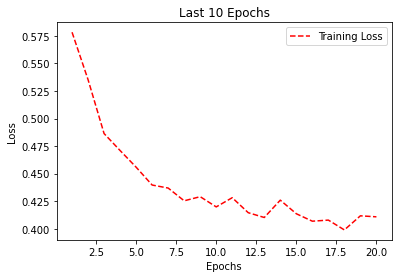

In [59]:
training_loss = history1.history['loss']
epoch_count = range(1, len(training_loss) + 1)
plt.figure()  
    # Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.legend(['Training Loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Last 10 Epochs')

In [60]:
model.load_weights('saved_model/model_30.h5')

In [61]:
# images = 'dataset/Flickr8k_Dataset/Flicker8k_Dataset/'

In [62]:
with open("/content/gdrive/MyDrive/ComputerVision/ImageCaption/Furniture-Dataset/image_features/encoded_test_images.pkl", "rb") as encoded_pickle:
    encoding_test = load(encoded_pickle)

In [63]:
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length1):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length1)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

In [64]:
list(encoding_test.keys())

['Flex Arm Chair in Black Colour by Make Home Happy._image_0.jpg',
 'Dolce Sofa Bed Two Seater With Storage in Blue Colour by Evok._image_0.jpg',
 'Graceful Two Seater Sofa in Half Leather In Brown Colour by Furnitech._image_0.jpg',
 'Combo Rester XXXL Bean Bag with Beans + Filled Foot Stool in Black Colour by Sattva._image_0.jpg',
 'Clinton Two Seater Sofa in Dark Brown Colour by Evok._image_0.jpg',
 'Shalom Arm Chair in Brown Colour by Creative Seating Systems._image_0.jpg']

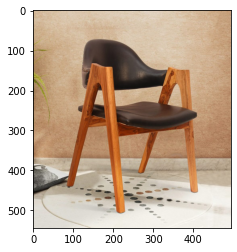

Greedy: black color chair with wooden legs


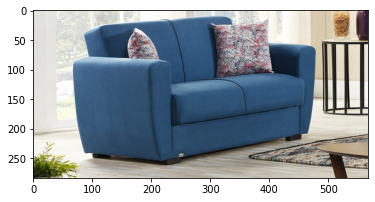

Greedy: beige color sofa with wooden legs


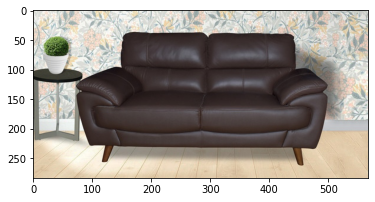

Greedy: blue color sofa with quilted pattern backrest


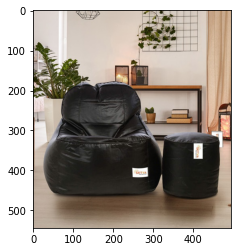

Greedy: 


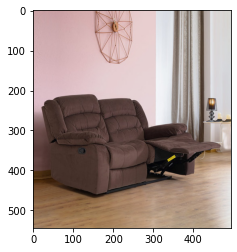

Greedy: brown color sofa with plush seats


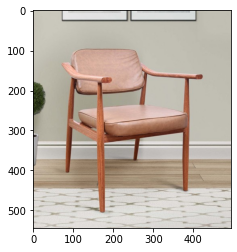

Greedy: green color chair with wooden legs


In [67]:
for i in range(len(encoding_test.keys())):

  z=1
  pic = list(encoding_test.keys())[i]
  image = encoding_test[pic].reshape((1,2048))
  x=plt.imread(images+pic)
  plt.imshow(x)
  plt.show()
  print("Greedy:",greedySearch(image))

**Generating Captions for other images**

In [ ]:
def get_images(path):
  subfolders = [x[0] for x in os.walk(path)]

  images = []
  for path in subfolders[1:]:

    img = glob.glob(path+"/" + '*.jpg')
    images.append(img)  
    #print(path)
    image_lists = [item for item in images]

  Images = []
  for i in range( len(image_lists)):
    for item in image_lists[i]:
      Images.append(item)
  return Images

In [ ]:
chair_image_path = '/content/gdrive/MyDrive/ComputerVision/ImageCaption/Furniture-Dataset/All-Images-Chair-Sofa-BeanBag/arm-chairs/'
sofa_image_path = '/content/gdrive/MyDrive/ComputerVision/ImageCaption/Furniture-Dataset/All-Images-Chair-Sofa-BeanBag/two-seater-sofa'
beanbag_image_path = '/content/gdrive/MyDrive/ComputerVision/ImageCaption/Furniture-Dataset/All-Images-Chair-Sofa-BeanBag/bean-bags'

chair_images = get_images(chair_image_path)
sofa_images = get_images(sofa_image_path)
banbeag_images = get_images(beanbag_image_path)


In [ ]:
#preprocessing the images
def preprocess(image_path):
    img = image.load_img(image_path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

# Encoding a given image into a vector of size (2048, )
def encode(image):
    image = preprocess(image) 
    fea_vec = model_new.predict(image) 
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1])
    return fea_vec

In [ ]:
# Call the funtion to encode all the test images - Execute this only once
start = time()
encoding_sample_chair = {}
for img in chair_images:
  encoding_sample_chair[img] = encode(img)
print("Time taken in seconds =", time()-start)

Time taken in seconds = 39.58211088180542


In [ ]:
chair_image_names = []
chair_image_descriptions = []
for i in range(len(encoding_sample_chair.keys())):

  z=1
  pic = list(encoding_sample_chair.keys())[i]
  chair_image_names.append(pic)
  image = encoding_sample_chair[pic].reshape((1,2048))
  chair_image_descriptions.append(greedySearch(image))

In [ ]:
# Call the funtion to encode all the test images - Execute this only once
start = time()
encoding_sample_sofa = {}
for img in sofa_images:
  encoding_sample_sofa[img] = encode(img)
print("Time taken in seconds =", time()-start)

Time taken in seconds = 58.3220272064209


In [ ]:
sofa_image_names = []
sofa_image_descriptions = []
for i in range(len(encoding_sample_sofa.keys())):
  z=1
  pic = list(encoding_sample_sofa.keys())[i]
  sofa_image_names.append(pic)
  image = encoding_sample_sofa[pic].reshape((1,2048))
  sofa_image_descriptions.append(greedySearch(image))

In [ ]:
# Call the funtion to encode all the test images - Execute this only once
start = time()
encoding_sample_beanbag = {}
for img in banbeag_images:
  encoding_sample_beanbag[img] = encode(img)
print("Time taken in seconds =", time()-start)

Time taken in seconds = 29.28320050239563


In [ ]:
beanbag_image_names = []
beanbag_image_descriptions = []
for i in range(len(encoding_sample_beanbag.keys())):
  z=1
  pic = list(encoding_sample_beanbag.keys())[i]
  beanbag_image_names.append(pic)
  image = encoding_sample_beanbag[pic].reshape((1,2048))
  beanbag_image_descriptions.append(greedySearch(image))

In [ ]:
chair_descriptions = pd.DataFrame(list(zip(chair_image_names,chair_image_descriptions )), columns = ['Chair_Image_Path','Description'])
chair_descriptions.to_csv('/content/gdrive/MyDrive/ComputerVision/ImageCaption/Furniture-Dataset/Captions/chair_descriptions.csv')

In [ ]:
sofa_descriptions = pd.DataFrame(list(zip(sofa_image_names,sofa_image_descriptions )), columns = ['Sofa_Image_Path','Description'])
sofa_descriptions.to_csv('/content/gdrive/MyDrive/ComputerVision/ImageCaption/Furniture-Dataset/Captions/sofa_descriptions.csv')

In [ ]:
beanbag_descriptions = pd.DataFrame(list(zip(beanbag_image_names,beanbag_image_descriptions )), columns = ['BeanBag_Image_Path','Description'])
beanbag_descriptions.to_csv('/content/gdrive/MyDrive/ComputerVision/ImageCaption/Furniture-Dataset/Captions/beanbag_descriptions.csv')